# In This notebook we will examine how flexible each model.
We will fully train each model on 5 classes from Cifar10 and see how fast each model reach accuracy thresholds on the othere 5 classes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms

import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path

import time

!pip install kymatio
from kymatio.torch import Scattering2D

!pip install kornia
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.utils.data import random_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.3 MB/s eta 0:00:00


In [2]:
L = 10  # L=10 got best accuracy on full training

DEBUG = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print_progress_every = 1
val_accuracy_storing_threshold = 50

checkpoint_dir = Path('./checkpoints')

# Make same seed for all notebooks
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# Define base, scat models and helper functions
# Base model
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(planes)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layer = []
        for s in strides:
            layer.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layer)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def MakeResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# Scat ResNet
class ScatResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, L=8):
        super(ScatResNet, self).__init__()
        self.in_planes = 64
        self.L = L
        self.scat_channels = (1 + L) * 3
        self.conv1 = nn.Conv2d(3, 64 - self.scat_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.scat1 = Scattering2D(J=1, shape=(32, 32), L=L, max_order=2, backend='torch')
        self.deconv1 = nn.ConvTranspose2d(in_channels=self.scat_channels, out_channels=self.scat_channels, groups=self.scat_channels, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layer = []
        for s in strides:
            layer.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layer)

    def forward(self, x):
        out = self.conv1(x)
        scat = self.scat1(x)
        scat = scat.view(scat.size(0), -1, 16,16)
        scat = self.deconv1(scat)
        out = torch.cat((out, scat), dim=1)
        out = F.relu(self.bn1(out))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def MakeScatResNet18(L, num_classes=10):
    return ScatResNet(BasicBlock, [2, 2, 2, 2], L=L, num_classes=num_classes)


# Functions
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            images = normalize(images)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=-1)
            total_images += labels.size(0)
            total_correct += (predictions == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    return model_accuracy

In [4]:
# Hyperparamters
# Note: Optimizers and schedulers are defined with the models

batch_size = 128
TRAIN_VAL_SPLIT = 0.8 # 80/20% split 

# Optimizer
lr = 0.1
momentum = 0.9
weight_decay = 5e-4

# Scheduler
T_max = 200

n_epochs = 1 if DEBUG else 200

# Standart mean and STD normaliztion
mean = torch.tensor([0.4914, 0.4822, 0.4465]).to(device)
std = torch.tensor([0.2023, 0.1994, 0.2010]).to(device)
normalize = K.Normalize(mean=mean, std=std)

criterion = nn.CrossEntropyLoss()

# Augmentations
aug_list = AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.2),
    K.RandomResizedCrop(size=(32,32), scale=(0.7, 1.0), p=0.5),
    normalize,
    same_on_batch=False
).to(device)

In [5]:
# Create a costume data loader- loads only the classes by list
class FilteredCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, *args, keep_classes=None, **kwargs):
        super(FilteredCIFAR10, self).__init__(*args, **kwargs)
        
        # Filter the data and targets
        if keep_classes is not None:
            # Convert keep_classes to a set for faster lookup
            keep_set = set(keep_classes)
            
            # Find indices of images that belong to our selected classes
            indices = [i for i, label in enumerate(self.targets) if label in keep_set]
            
            # Overwrite the data and targets with only the selected indices
            self.data = self.data[indices]
            self.targets = np.array(self.targets)[indices].tolist()
            
            # Create a mapping to make labels 0, 1, 2, 3, 4
            self.class_map = {c: i for i, c in enumerate(keep_classes)}
            
            # Apply the mapping to all targets
            self.targets = [self.class_map[t] for t in self.targets]

    # Override __getitem__ to ensure we return the transformed image and mapped label
    def __getitem__(self, index):
        img, target = super(FilteredCIFAR10, self).__getitem__(index)
        return img, target

In [ ]:
# Create our train and retrain sets
# We use same hyperparameters here for both ResNet and ScatNet, so no need for validation set
class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
mid_idx = len(class_names) // 2
classes_1st = list(range(mid_idx))
classes_2nd = list(range(mid_idx, len(class_names)))

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)

# 1st set of classes
train_val_1st = FilteredCIFAR10(
    keep_classes=classes_1st,
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 80/20% split
train_size = int(TRAIN_VAL_SPLIT * len(train_val_1st))
val_size = len(train_val_1st) - train_size
train_1st, val_1st = random_split(
    train_val_1st,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

test_1st =  FilteredCIFAR10(
    keep_classes=classes_1st,
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 2nd set of classes
train_2nd = FilteredCIFAR10(
    keep_classes=classes_2nd,
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_2nd =  FilteredCIFAR10(
    keep_classes=classes_2nd,
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [7]:
# Set data loaders
NUM_WORKERS = 2 

# 1st set
trainloader_1st = torch.utils.data.DataLoader(
    train_1st, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=NUM_WORKERS
)

val_loader_1st = torch.utils.data.DataLoader(
    val_1st, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=NUM_WORKERS
)

testloader_1st = torch.utils.data.DataLoader(
    test_1st, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

# 2nd set
# Note: We Only compare speed for reaching accuracy thresholds here
#       So no need for validation set
trainloader_2nd = torch.utils.data.DataLoader(
    train_2nd, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

testloader_2nd = torch.utils.data.DataLoader(
    test_2nd, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

In [8]:
# Create our models, optimizers and schedulers
resnet = MakeResNet18(num_classes=len(classes_1st)).to(device)
resnet_optimizer = torch.optim.SGD(
    resnet.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)
resnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    resnet_optimizer,
    T_max=T_max)

scatnet = MakeScatResNet18(L=L, num_classes=len(classes_1st)).to(device)
scatnet_optimizer = torch.optim.SGD(
    scatnet.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)
scatnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    scatnet_optimizer,
    T_max=T_max)

In [9]:
# Define training function
def train_model(
    model, 
    trainloader, 
    testloader, 
    optimizer, 
    scheduler, 
    criterion, 
    n_epochs, 
    device, 
    checkpoint_dir, 
    model_name="Model", 
    aug_list=None,
    val_accuracy_storing_threshold=50,
    print_progress_every=1,
    DEBUG=False
):
    """
    Trains a model and returns the stats dictionary.
    """
    
    # Initialize Stats
    stats = {
        'total_training_time': 0,
        'loss': [],
        'time_per_epoch': [],
        'total_time_per_epoch': [],
        'val_accuracy': [],
        'max_val_accuracy': 0,
        'allocated_memory': [],
        'reserved_memory': []
    }

    start_time = time.time()
    checkpoint_path = Path(checkpoint_dir) # Ensure it's a Path object
    checkpoint_path.mkdir(parents=True, exist_ok=True) # Create dir if missing

    print(f"\n=== Starting Training: {model_name} with {n_epochs} epochs ===")

    for epoch in range(n_epochs):
        model.train()
        iteration_losses = []
        epoch_start_time = time.time()
        
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            if aug_list:
                inputs = aug_list(inputs)

            outputs = model(inputs)

            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            iteration_losses.append(loss.item())

        scheduler.step()
        epoch_end_time = time.time()

        # Validation
        model.eval()
        # Assuming calculate_accuracy is defined elsewhere in your code
        val_accuracy = calculate_accuracy(model, testloader, device)

        # Track stats
        stats['loss'].append(np.mean(iteration_losses))
        stats['val_accuracy'].append(val_accuracy)
        stats['allocated_memory'].append(torch.cuda.memory_allocated())
        stats['reserved_memory'].append(torch.cuda.memory_reserved())
        stats['time_per_epoch'].append(epoch_end_time - epoch_start_time)
        stats['total_time_per_epoch'].append(time.time() - start_time)

        # Store best model
        if val_accuracy > stats['max_val_accuracy']:
            if val_accuracy > val_accuracy_storing_threshold:
                stats['max_val_accuracy'] = val_accuracy
                save_file = checkpoint_path / f"{model_name}_finetune_exp.pth"
                
                state = {
                    'net': model.state_dict(),
                    'epoch': epoch,
                    'acc': val_accuracy
                }
                torch.save(state, save_file)
                if (epoch % print_progress_every) == 0:
                    print(f"    --> New Best Saved: {val_accuracy:.2f}%")

        if DEBUG:
            print('==> Saving model ... DEBUG')
            state = {
                'net': model.state_dict(),
                'epoch': epoch,
                'acc':val_accuracy
            }
            save_path = checkpoint_dir / f"{model_name}_finetune_exp.pth"
            torch.save(state, save_path)
            
        # Print progress
        if (epoch % print_progress_every) == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Loss: {stats['loss'][-1]:.3f} | Test Acc: {stats['val_accuracy'][-1]:.2f}%")

    stats['total_training_time'] = time.time() - start_time
    print(f"=== Finished {model_name}. Total Time: {stats['total_training_time']:.1f}s ===")
    
    return stats

In [10]:
# Train models
# Train ResNet
print("--> Training Standard ResNet on First 5 Classes...")
resnet_stats = train_model(
    model=resnet,
    trainloader=trainloader_1st,
    testloader=val_loader_1st,
    optimizer=resnet_optimizer,
    scheduler=resnet_scheduler,
    criterion=criterion,
    n_epochs=n_epochs,
    device=device,
    checkpoint_dir=checkpoint_dir,
    model_name="ResNet",
    aug_list=aug_list,
    DEBUG=DEBUG
)

# Train ScatNet
print("\n--> Training ScatNet on First 5 Classes...")
scatnet_stats = train_model(
    model=scatnet,
    trainloader=trainloader_1st,
    testloader=testloader_1st,
    optimizer=scatnet_optimizer,
    scheduler=scatnet_scheduler,
    criterion=criterion,
    n_epochs=n_epochs,
    device=device,
    checkpoint_dir=checkpoint_dir,
    model_name="ScatNet",
    aug_list=aug_list,
    DEBUG=DEBUG
)

--> Training Standard ResNet on First 5 Classes...

=== Starting Training: ResNet with 200 epochs ===
Epoch 1/200 | Loss: 1.862 | Test Acc: 48.98%
    --> New Best Saved: 55.04%
Epoch 2/200 | Loss: 1.144 | Test Acc: 55.04%
    --> New Best Saved: 61.68%
Epoch 3/200 | Loss: 1.034 | Test Acc: 61.68%
Epoch 4/200 | Loss: 0.952 | Test Acc: 59.08%
    --> New Best Saved: 65.88%
Epoch 5/200 | Loss: 0.886 | Test Acc: 65.88%
Epoch 6/200 | Loss: 0.836 | Test Acc: 64.90%
    --> New Best Saved: 71.68%
Epoch 7/200 | Loss: 0.791 | Test Acc: 71.68%
    --> New Best Saved: 73.20%
Epoch 8/200 | Loss: 0.739 | Test Acc: 73.20%
Epoch 9/200 | Loss: 0.713 | Test Acc: 71.96%
    --> New Best Saved: 74.30%
Epoch 10/200 | Loss: 0.674 | Test Acc: 74.30%
    --> New Best Saved: 75.70%
Epoch 11/200 | Loss: 0.645 | Test Acc: 75.70%
    --> New Best Saved: 76.52%
Epoch 12/200 | Loss: 0.591 | Test Acc: 76.52%
Epoch 13/200 | Loss: 0.559 | Test Acc: 75.76%
    --> New Best Saved: 77.72%
Epoch 14/200 | Loss: 0.519 | T

In [11]:
# Check model on test
# Load best models
# ResNet
resnet_trained = resnet = MakeResNet18(num_classes=len(classes_1st)).to(device)
checkpoint = torch.load(
    checkpoint_dir / f"ResNet_finetune_exp.pth",
    map_location=device)
resnet_trained.load_state_dict(checkpoint['net'])
resnet_trained.eval()
print(f'Final test accuracy for ResNet18 is: {calculate_accuracy(resnet_trained, testloader_1st, device):.3f}')

# ScatNet
scatnet_trained = MakeScatResNet18(L=L, num_classes=len(classes_1st)).to(device)
checkpoint = torch.load(
    checkpoint_dir / f"ScatNet_finetune_exp.pth",
    map_location=device)
scatnet_trained.load_state_dict(checkpoint['net'])
scatnet_trained.eval()
print(f'Final test accuracy for ScatNEt18 is: {calculate_accuracy(scatnet_trained, testloader_1st, device):.3f}')


Final test accuracy for ResNet18 is: 95.100
Final test accuracy for ScatNEt18 is: 94.500


In [12]:
def refine_model(
    model, 
    trainloader, 
    testloader, 
    optimizer, 
    scheduler, 
    criterion, 
    n_epochs, 
    device, 
    checkpoint_dir, 
    model_name="RefinedModel", 
    aug_list=None,
    val_accuracy_storing_threshold=50,
    print_progress_every=1,
    early_stop_target=90.0,  # <--- NEW PARAMETER
    DEBUG=False
):
    """
    Fine-tunes a model, tracks milestones, and STOPS if target accuracy is reached.
    """
    
    target_milestones = [50, 55, 60, 65, 70, 75, 80, 85, 90]
    
    stats = {
        'loss': [],
        'val_accuracy': [],
        'max_val_accuracy': 0,
        'milestones': {}, 
        'total_training_time': 0
    }

    start_time = time.time()
    checkpoint_path = Path(checkpoint_dir)
    checkpoint_path.mkdir(parents=True, exist_ok=True)

    print(f"\n>>> Refinement Started: {model_name}")
    print(f"    Targeting Milestones: {target_milestones}")
    print(f"    Early Stopping Target: {early_stop_target}%")

    for epoch in range(n_epochs):
        model.train()
        iteration_losses = []
        
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            if aug_list: inputs = aug_list(inputs)

            outputs = model(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            iteration_losses.append(loss.item())

        scheduler.step()
        
        # Validation
        model.eval()
        val_accuracy = calculate_accuracy(model, testloader, device)
        current_time = time.time() - start_time

        # --- MILESTONE CHECKER ---
        for m in target_milestones:
            if val_accuracy >= m and m not in stats['milestones']:
                stats['milestones'][m] = {
                    'epoch': epoch + 1,
                    'time': current_time
                }
                print(f"    HIT {m}% Accuracy at Epoch {epoch+1} ({current_time:.1f}s)")

        # Save Stats
        stats['loss'].append(np.mean(iteration_losses))
        stats['val_accuracy'].append(val_accuracy)

        # Save Best Model
        if val_accuracy > stats['max_val_accuracy']:
            stats['max_val_accuracy'] = val_accuracy
            if val_accuracy > val_accuracy_storing_threshold:
                state = {'net': model.state_dict(), 'epoch': epoch, 'acc': val_accuracy}
                torch.save(state, checkpoint_path / f"{model_name}_refined.pth")
        
        # Print Progress
        if (epoch % print_progress_every) == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Loss: {stats['loss'][-1]:.3f} | Acc: {val_accuracy:.2f}%")

        # --- EARLY STOPPING CHECK ---
        if val_accuracy >= early_stop_target:
            print(f"\n GOAL REACHED! Stopping early at {val_accuracy:.2f}%")
            break

        if DEBUG:
            break

    stats['total_training_time'] = time.time() - start_time
    print(f">>> Refinement Complete. Total Time: {stats['total_training_time']:.1f}s")
    
    return stats

In [13]:
# --- RUN REFINEMENT ON SET 2 ---

print("\n" + "="*40)
print(" STARTING FINE-TUNING (Stop at 90%)")
print("="*40)

# 1. Reset Optimizers/Schedulers
resnet_optimizer = torch.optim.SGD(resnet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scatnet_optimizer = torch.optim.SGD(scatnet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

resnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(resnet_optimizer, T_max=n_epochs)
scatnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(scatnet_optimizer, T_max=n_epochs)

# 2. Refine ResNet
resnet_refine_stats = refine_model(
    model=resnet,
    trainloader=trainloader_2nd,
    testloader=testloader_2nd,
    optimizer=resnet_optimizer,
    scheduler=resnet_scheduler,
    criterion=criterion,
    n_epochs=n_epochs,
    device=device,
    checkpoint_dir=checkpoint_dir,
    model_name="ResNet_Refined",
    aug_list=aug_list,
    early_stop_target=90.0,
    DEBUG=DEBUG
)

# 3. Refine ScatNet
scatnet_refine_stats = refine_model(
    model=scatnet,
    trainloader=trainloader_2nd,
    testloader=testloader_2nd,
    optimizer=scatnet_optimizer,
    scheduler=scatnet_scheduler,
    criterion=criterion,
    n_epochs=n_epochs,
    device=device,
    checkpoint_dir=checkpoint_dir,
    model_name="ScatNet_Refined",
    aug_list=aug_list,
    early_stop_target=90.0,
    DEBUG=DEBUG
)


 STARTING FINE-TUNING (Stop at 90%)

>>> Refinement Started: ResNet_Refined
    Targeting Milestones: [50, 55, 60, 65, 70, 75, 80, 85, 90]
    Early Stopping Target: 90.0%
    HIT 50% Accuracy at Epoch 1 (26.0s)
    HIT 55% Accuracy at Epoch 1 (26.0s)
    HIT 60% Accuracy at Epoch 1 (26.0s)
    HIT 65% Accuracy at Epoch 1 (26.0s)
    HIT 70% Accuracy at Epoch 1 (26.0s)
Epoch 1/200 | Loss: 0.691 | Acc: 71.44%
    HIT 75% Accuracy at Epoch 2 (52.3s)
    HIT 80% Accuracy at Epoch 2 (52.3s)
    HIT 85% Accuracy at Epoch 2 (52.3s)
Epoch 2/200 | Loss: 0.395 | Acc: 86.74%
Epoch 3/200 | Loss: 0.323 | Acc: 84.38%
Epoch 4/200 | Loss: 0.284 | Acc: 87.84%
Epoch 5/200 | Loss: 0.258 | Acc: 85.44%
Epoch 6/200 | Loss: 0.244 | Acc: 88.30%
    HIT 90% Accuracy at Epoch 7 (182.6s)
Epoch 7/200 | Loss: 0.228 | Acc: 91.64%

 GOAL REACHED! Stopping early at 91.64%
>>> Refinement Complete. Total Time: 182.7s

>>> Refinement Started: ScatNet_Refined
    Targeting Milestones: [50, 55, 60, 65, 70, 75, 80, 85, 9

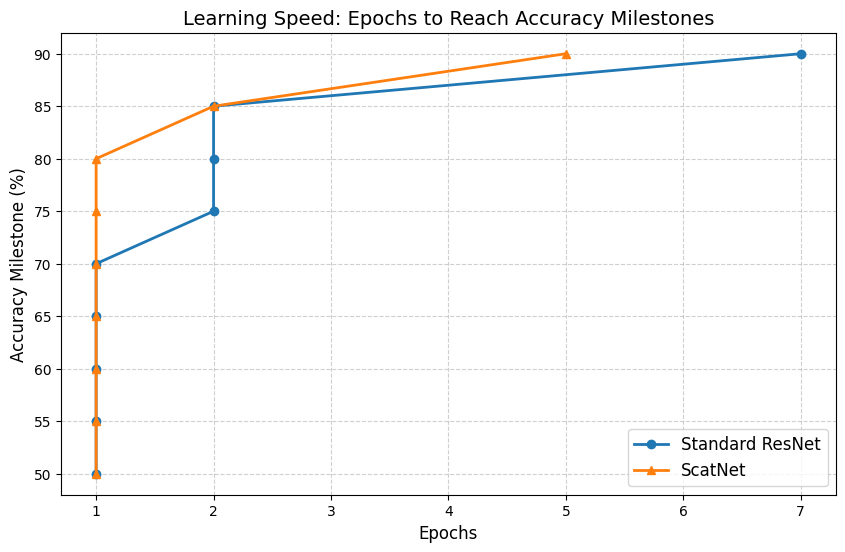

In [14]:
# Plot results


def get_milestone_points(stats_dict):
    """
    Extracts sorted (epoch, accuracy) pairs from the stats dictionary.
    """
    milestones = stats_dict.get('milestones', {})
    
    # Sort by accuracy (the key) so the line is drawn correctly
    sorted_accuracies = sorted(milestones.keys())
    
    # Get the corresponding epoch for each milestone
    epochs = [milestones[acc]['epoch'] for acc in sorted_accuracies]
    
    return epochs, sorted_accuracies

# 1. Extract Data
res_epochs, res_accs = get_milestone_points(resnet_refine_stats)
scat_epochs, scat_accs = get_milestone_points(scatnet_refine_stats)

# 2. Plot
plt.figure(figsize=(10, 6))

# Plot ResNet
plt.plot(res_epochs, res_accs, marker='o', linestyle='-', linewidth=2, label='Standard ResNet')

# Plot ScatNet
plt.plot(scat_epochs, scat_accs, marker='^', linestyle='-', linewidth=2, label='ScatNet')

# 3. Formatting
plt.title('Learning Speed: Epochs to Reach Accuracy Milestones', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy Milestone (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.yticks(range(50, 95, 5)) # clear Y-axis ticks for 50, 55, 60...

plt.show()